In [2]:
# Purpose of this program: To predict water volume over time, for data which is fairly sinusoidal on a tilted axis. 

Saving ShastaAllData_1125Days_WaterVolume.csv to ShastaAllData_1125Days_WaterVolume.csv


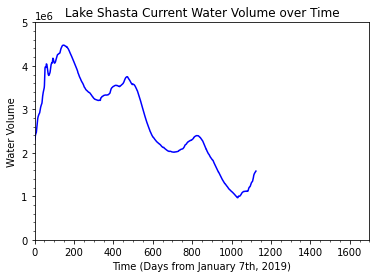

In [1]:
# Imports and file choice
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib

from google.colab import files
uploaded = files.upload()

# Import data from a csv
df = pd.read_csv('ShastaAllData_1125Days_WaterVolume.csv', header=0, names = ['DATE', 'STORAGEVOLUME', 'UNNECESSARY'])
df.drop('UNNECESSARY',axis = 1, inplace = True)
df.set_index('DATE', inplace=True)
df.head()

# Plot the data
plt.title('Lake Shasta Current Water Volume over Time')
plt.plot(df.index, df.STORAGEVOLUME, color = 'blue')
plt.suptitle("")
plt.xlabel('Time (Days from January 7th, 2019)')
plt.ylim([0, 5000000])
plt.xlim([0, 1700])
plt.ylabel('Water Volume')
plt.minorticks_on()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80)                26240     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 26,321
Trainable params: 26,321
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
34/34 - 9s - loss: 0.9869 - val_loss: 2.7158 - 9s/epoch - 251ms/step
Epoch 2/200
34/34 - 1s - loss: 0.7020 - val_loss: 1.9992 - 635ms/epoch - 19ms/step
Epoch 3/200
34/34 - 1s - loss: 0.4751 - val_loss: 1.4112 - 694ms/epoch - 20ms/step
Epoch 4/200
34/34 - 1s - loss: 0.2906 - val_loss: 0.9372 - 588ms/epoch - 17ms/step
Epoch 5/200
34/34 - 0s - loss: 0.1525 - val_loss: 0.5805 - 390ms/epoch - 11ms/step
Epoch 6/200
34/34 - 0s - loss: 0.0675 - val_loss: 0.3410 - 349ms/epoch - 10ms/step
Epoch 7/200
34/34 - 0s - loss: 0.0294 - val_loss: 0.1983 - 334ms/epoch - 10ms/step
Epoch 8/200
34/34 - 0s - loss: 0.0172 - val_loss: 0.1188 - 355ms/epoch - 10ms/step
Epoch 9/200
34/34 - 0s - loss: 0.0133 - val_loss: 0.0750 - 373ms/epoch - 11ms/step
Epoch 10/200
34/34 - 0s - loss: 0.0117 - val_loss: 0.0507 - 377ms/epoch - 11ms/step
Epoch 11/200
34/34 - 0s - loss: 0.0111 - val_loss: 0.0373 - 323ms/epoch - 10ms/step
Epoch 12/200
34/34 - 0s - loss: 0.0108 - val_loss: 0.0298 - 351ms/epoch - 10ms/step
Epo

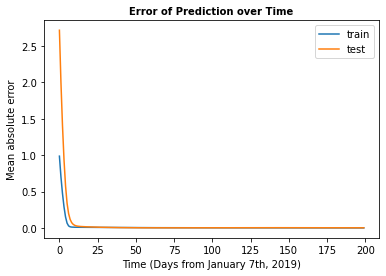

In [3]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# Load the water volume levels into the variable values
values = df.values
values = values.astype('float32')
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
joblib.dump(scaler, 'scaler.gz')

backward_steps = 10
n_features = df.shape[1]

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
     n_vars = 1 if type(data) is list else data.shape[1]
     df = pd.DataFrame(data)
     cols, names = list(), list()
     for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     
     for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
          else:
               names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

          agg = pd.concat(cols, axis=1)
          agg.columns = names

          if dropnan:
              agg.dropna(inplace=True)
          return agg

# Frame as supervised learning
reframed = series_to_supervised(scaled, backward_steps, 1)

# Split into train and test sets
values = reframed.values
threshold = int(0.9* len(reframed))

# 90% of data is for training
train = values[:threshold, :]
test = values[threshold:, :]

# Split into input and outputs 
n_obs = backward_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], backward_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], backward_steps, n_features))

# Design network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.0001))
model.summary()

# Define early stopping parameter
history = model.fit(train_X, train_y, epochs=200, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
plt.title('Error of Prediction over Time', fontsize=10, loc='center', fontweight='bold')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Mean absolute error')
plt.xlabel('Time (Days from January 7th, 2019)')
plt.legend()
plt.show()


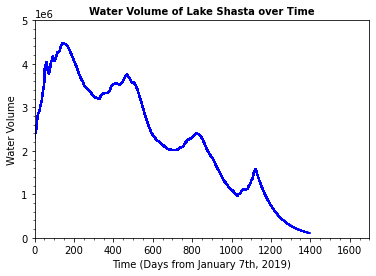

In [4]:
INPUTFINALDAY = 1400
n_steps = 10
n_features = 1
numRepeat = INPUTFINALDAY - 1125

def getScaler(num, INDEX):
  returning = [[ int(df.loc[num + INDEX, "STORAGEVOLUME"]) ], [1]]
  returning = scaler.fit_transform(returning)
  return returning[0][0]

for INDEX in range (numRepeat):
  # getting 10 previous values from the dataframe and using them as inputs 
  valOne = getScaler(1114, INDEX)
  valTwo = getScaler(1115, INDEX)
  valThree = getScaler(1116, INDEX)
  valFour = getScaler(1117, INDEX)
  valFive = getScaler(1118, INDEX)
  valSix = getScaler(1119, INDEX)
  valSeven = getScaler(1120, INDEX)
  valEight = getScaler(1121, INDEX)
  valNine = getScaler(1122, INDEX)
  valTen = getScaler(1123, INDEX)
  x_input = array([valOne, valTwo, valThree, valFour, valFive, valSix, valSeven, valEight, valNine, valTen])

  # make the input fit the shape that the model takes
  x_input = x_input.reshape((1, n_steps, n_features))

  # convert prediction from scaler to normal
  yhat = model.predict(x_input, verbose=0)
  inv_yhat = scaler.inverse_transform(yhat)

  # add current prediction to dataframe
  arrTwo = {'STORAGEVOLUME':[str(int(inv_yhat))]}
  df2 = pd.DataFrame(arrTwo)
  df = pd.concat([df, df2], ignore_index=True)

  # plot results
  plt.title('Water Volume of Lake Shasta over Time', fontsize=10, loc='center', fontweight='bold')

  plt.plot(df.index, df.STORAGEVOLUME, color = 'blue')
  plt.suptitle("")
  plt.xlabel('Time (Days from January 7th, 2019)')
  plt.ylim([0, 5000000])
  plt.xlim([0, 1700])
  plt.ylabel('Water Volume')
  plt.minorticks_on()